# Проект для «Викишоп» c SentanceTranformer

Интернет-магазин _«Викишоп»_ запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Требуется обучить модель классифицировать комментарии на позитивные и негативные. Качество модели должно оцениваться метрикой *F1*, и её значение не должно быть меньше 0.75.

В распоряжении набор данных с разметкой о токсичности комментариев. Столбец `text` содержит текст комментария, а `toxic` — оценка этих комментариев: 0 - позитивный, 1 - негативный (целевой признак).

**Содержание:**
1. [Подготовка](#section_1)
2. [Чтение и знакомство с данными](#section_2)
3. [TF-IDF (CPU)](#section_3)
    1. [LogisticRegression](#section_3A)
    2. [CatBoost](#section_3B)
4. [SentanceTransformer (GPU)](#section_4)
    1. [LogisticRegression](#section_4A)
    2. [CatBoost (CPU)](#section_4B)
    3. [CatBoost (GPU)](#section_4C)
5. [Борьба с дисбалансом](#section_4)
    1. [Баланс классов](#section_4A)
    2. [Изменение порога классификации](#section_4B)
    3. [DownSampling](#section_4C)
6. [Итоговое тестирование](#section_6)
7. [Чек-лист](#section_7)

<a id='section_1'></a>
## Подготовка

In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.9 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=b36c13605128124da71dfb66688f354933ed7be9b57f24c9393002d8b6a11c6f
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence_transformers


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.4 MB/s eta 0:00:00


In [ ]:
# импорт основных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# импорт спец. библиотек
import os
import re
import nltk
import tensorflow as tf
from pymystem3 import Mystem
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier
from tqdm import notebook

In [ ]:
# импорт элементов библиотеки SKLEARN
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# константы
RANDOM_STATE = 42

# адреса расположения датасета
home_path = 'datasets/toxic_comments.csv'
server_path = '/datasets/toxic_comments.csv'
google_path = '/content/drive/Othercomputers/ProBook/Yandex_Practicum/datasets/toxic_comments.csv'

<a id='section_2'></a>
## Чтение и знакомство с данными

In [ ]:
# домашняя версия
if os.path.exists(home_path):
    df = pd.read_csv(home_path)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    print('Файл прочитан.')

# сетевая версия
elif os.path.exists(server_path):
    df = pd.read_csv(server_path)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    print('Файл прочитан.')

else: # google версия
    from google.colab import drive
    drive.mount('/content/drive')
    if os.path.exists(google_path):
        df = pd.read_csv(google_path)
        df.drop(['Unnamed: 0'], axis=1, inplace=True)
        print('Файл прочитан.')

    # обработка ошибки
    else:
        raise SystemError('Reading was failed. Perhaps, the path was wrong.')

Mounted at /content/drive
Файл прочитан.


----------------< Исходный датасет >----------------


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0



------< Техническая информация >------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None
Дубликаты: 0
Типовые значения колонки 'toxic': [0 1]

--------< Соотношение типов комментариев >--------


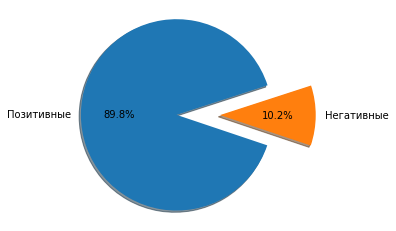

In [ ]:
print('----------------< Исходный датасет >----------------')
display(df.head())

print('\n------< Техническая информация >------')
print(df.info())
print("Дубликаты:", len(df[df.duplicated()]))
print("Типовые значения колонки 'toxic':", df['toxic'].unique())

# распределение токсичности комментариев
print('\n--------< Соотношение типов комментариев >--------')
plt.pie(df['toxic'].value_counts(),
        labels=['Позитивные', 'Негативные'],
        autopct='%1.1f%%',
        startangle=18,
        explode=(0.5, 0),
        shadow=True,
        radius=1.10);

**Итог:** Датасет содержит почти **160 тыс. комментариев**.
- Колонка `Unnamed: 0` вероятней всего содержала индексы, но в них присутствовали пропуски. По этой причине она была удалена.
- Присутствует дисбаланс классов: позитивных комментариев больше в 9 раз.
- Тип данных соответствует содержанию в колонка.
- Пропуски и дубликаты - отсутствуют.

**Кодирование текста.**
Задача модели, предсказывающей эмоциональный оттенок комментариев, будет разделена на две подзадачи:
- оцифровка текста;
- поиск закономерностей и оценка текста.

Каждая из этих задач будут реализованы отдельными спец. модель. В этом разделе будут разобраны несколько способов преобразования текста.

<a id='section_3'></a>
## TF-IDF (CPU)

Cамый примитивны способ: использовать только слова встречаемые в исходном тексте.  Обучение и предсказание происходит только на словаре, который сформировывается из слов комментариев.

Оцифровка слов происходит за счёт посчёта их важности, величиной TF-IDF. То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

_Примечание_: бóльшая величина TF-IDF говорит об уникальности слова в тексте по отношению к корпусу. Чем чаще оно встречается в конкретном тексте и реже в остальных, тем выше значение TF-IDF.

In [ ]:
# инициализация класса для лемматизации
mystem = Mystem()

# функция лемматизации и очистки текста
def lemm_clear_text(text):
    lemm_list = mystem.lemmatize(text)
    lemm_text = "".join(lemm_list)   
    text = re.sub(r'[^ a-zA-Z]', '', lemm_text)
    text = text.split()
    text =  ' '.join(text)
    return text

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
# лематизация текста
for i in notebook.tqdm(range(len(df['text']))):
    df.loc[i, 'lemm_text'] = lemm_clear_text(df.loc[i, 'text'])

  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:
# пример лемматизированного текста
df.head(3)

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,ExplanationWhy the edits made under my usernam...
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...


In [ ]:
# ! для работы в Colab без GPU
# сохранение лемматизированного теста

#lemm_dataset_path = '/content/drive/Othercomputers/ProBook/Yandex_Practicum/datasets/toxic_comments_lemm.csv'
#df.to_csv(lemm_dataset_path, index_label=False)

In [ ]:
# ! для работы в Colab без GPU
# чтение лемматизированного теста

#df_lemm = pd.read_csv(lemm_dataset_path)
#display(df_lemm.head(3))
#display(df_lemm.info())

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,ExplanationWhy the edits made under my usernam...
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       159292 non-null  object
 1   toxic      159292 non-null  int64 
 2   lemm_text  159281 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


None

In [ ]:
# скачивание стоп слов
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# создание TF-IDF векторизатора с стопсловами (слова без смысловой нагрузки)
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# подготовка обучающей выборки
target = df['toxic']
features = df['lemm_text']

# выделение тренировочной выборки
X_train_tfidf, X_other, Y_train_tfidf, Y_other = train_test_split(features,
                                                                  target,
                                                                  stratify = target,
                                                                  train_size = 0.80,
                                                                  random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_tfidf, X_test_tfidf, Y_valid_tfidf, Y_test_tfidf = train_test_split(X_other,
                                                                            Y_other,
                                                                            stratify = Y_other,
                                                                            test_size = 0.50,
                                                                            random_state = RANDOM_STATE)
# "кодирование" текста
count_tf_idf.fit(X_train_tfidf)
X_train_tfidf = count_tf_idf.transform(X_train_tfidf)
X_valid_tfidf = count_tf_idf.transform(X_valid_tfidf)
X_test_tfidf  = count_tf_idf.transform(X_test_tfidf)

print('Количество признаков:', X_train_tfidf.shape[1])

Количество признаков: 232828


Далее следует текстирование преобразованного текста. Поскольку в датасете присутствует дисбаланс, а целевая метрика _F1_ демонстрирует условную параллельность _Recall_ и _Precision_.
В дополнении к ней будет выводится значение этих метрик и применяться построение PR-кривой и значения порогов классификации.

Для оценки качества преобразования, закодированный текст сразу будет тестироваться на следующих моделях классификации:
- LogisticRegression;
- CatBoostClassifier.

<a id='section_3A'></a>
### LogisticRegression

In [ ]:
# объявление модели Логистической регрессии и её гиперпар.
LogRer_tfidf = LogisticRegression(solver = 'sag',
                                  random_state = RANDOM_STATE)

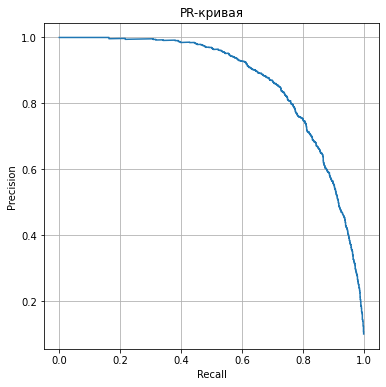

F1 = 0.722
Recall = 0.590
Precision = 0.930


In [ ]:
# тестирование TF-IDF на Logistic Regression
LogRer_tfidf.fit(X_train_tfidf, Y_train_tfidf)
prediction_valid = LogRer_tfidf.predict(X_valid_tfidf)
proba_valid = LogRer_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=(6, 6))
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

<a id='section_3B'></a>
### CatBoost

In [ ]:
# модель градиентного бустинга CatBoost (CPU) 16 minutes
CatBoost_tfidf = CatBoostClassifier(verbose = 100, # шаг вывода информации о процессе обучения
                                    task_type = 'CPU', # среда работы модели
                                    max_depth = 3, # макс. глубина базовых моделей
                                    learning_rate = 1, # шаг градиентного бустинга
                                    eval_metric = 'F1') # метрика оценки модели 

In [ ]:
# обучение CatBoost на фичах TF-IDF
CatBoost_tfidf.fit(X_train_tfidf, Y_train_tfidf)

0:	learn: 0.4073690	total: 1.03s	remaining: 17m 5s
100:	learn: 0.7296578	total: 2m 25s	remaining: 21m 39s
200:	learn: 0.7658168	total: 4m 39s	remaining: 18m 31s
300:	learn: 0.7808109	total: 6m 26s	remaining: 14m 56s
400:	learn: 0.7934946	total: 8m 8s	remaining: 12m 9s
500:	learn: 0.8067898	total: 9m 49s	remaining: 9m 46s
600:	learn: 0.8205840	total: 11m 51s	remaining: 7m 52s
700:	learn: 0.8279519	total: 13m 52s	remaining: 5m 55s
800:	learn: 0.8313118	total: 15m 44s	remaining: 3m 54s
900:	learn: 0.8336482	total: 17m 45s	remaining: 1m 57s
999:	learn: 0.8352148	total: 19m 51s	remaining: 0us


In [ ]:
# ! для работы в Colab без GPU
# сохранение / чтение предобученной модели

#CatBoost_tfidf_path = '/content/drive/Othercomputers/ProBook/Yandex_Practicum/CatBoost_TF-IDF.cbm'
#CatBoost_tfidf.load_model(CatBoost_tfidf_path, format='cbm')
#CatBoost_tfidf.save_model(CatBoost_tfidf_path, format="cbm", export_parameters=None)

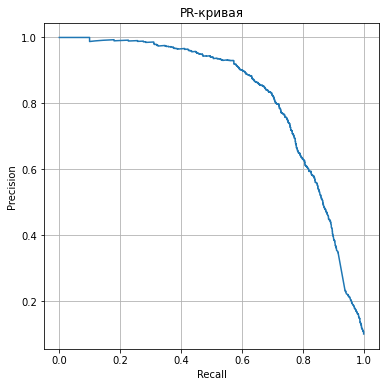

F1 = 0.757
Recall = 0.694
Precision = 0.833


In [ ]:
# тестирование TF-IDF на CatBoost
prediction_valid = CatBoost_tfidf.predict(X_valid_tfidf)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=(6, 6))
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

**Итог:**
- Лемматизация текста занимает около 2,5 минут. На этот процесс не влияет применение графического процессора.
- Процесс векторизации подготовленного текста с помощью `TfidfVectorizer` - мгновенный. Слова, не имеющие смысловой нагрузки - удалены.
- Логистическая регрессия имеет значение целевой метрики F1 = 0.72
- Градиентный бустинг CatBoost F1 = 0.76, но время обучения на CPU 16 минут. Применение GPU требует большого объема ОП, что не позволяет его запустить на базовых мощностях Colab.

Ключевым недостатком является большое количество признаков и объём памяти, которую они занимают. Это затрудняет использование GPU, к примеру для ускорения обучения модели CatBoost.

На данном этапе результат тестирования - приемлемый. Но необходимо учесть присутствующий дисбалланс классов. Этой теме будет посвящен отдельный раздел.

<a id='section_4'></a>
## SentanceTranformer (GPU)



В этом разделе будет применён альтернативный способ преобразования. TF-IDF векторизатор не учитывает контекст в отличии от предобученной модели для SentanceTranformer. Она позволяет создавать эбеддинги (вектора), которые сохраняют контекст комментариев.

Меньшее количество признаков и требуемый объём ОП позволяет применять GPU и ускорять процесс работы с большим объёмом данных.

In [ ]:
# инициализация предобученной модели преобразования текста в вектора
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# назначение GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# кодирование текста GPU 25 minutes
ST_embeddings = []

with tf.device('/device:GPU:0'):
    for i in notebook.tqdm(range(len(df['text']))):
        ST_embeddings.append(sentence_transformer.encode(df.loc[i, 'text']))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:
# кодирование текста GPU 3:20 minutes (короткая запись)
ST_embeddings = []

with tf.device('/device:GPU:0'):
    ST_embeddings = sentence_transformer.encode(df['text'])

In [ ]:
# ! для работы в Colab без GPU
# сохранение / чтение эбеддингов

#embeddings_path = '/content/drive/Othercomputers/ProBook/Yandex_Practicum/datasets/ST_embeddings.csv'
#pd.DataFrame(ST_embeddings).to_csv(embeddings_path, index_label=False)

#ST_embeddings = pd.read_csv(embeddings_path)
#display(ST_embeddings.head())
#display(ST_embeddings.info())

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.028033,0.056780,0.091350,0.032315,0.048531,0.024905,-0.001665,-0.035811,0.015926,-0.019791,...,-0.001886,0.004119,0.005928,0.077336,-0.058341,-0.031362,0.001371,0.014139,-0.026163,-0.041901
1,-0.051320,0.087537,0.055453,-0.061086,0.071453,-0.035208,0.104684,-0.090926,-0.009081,-0.010960,...,0.082233,-0.088611,0.035271,0.029772,0.046203,0.039858,0.092982,0.020118,-0.092164,0.018549
2,0.010958,0.092103,0.051115,0.013316,0.018948,0.023738,-0.033800,-0.098386,0.031458,0.026289,...,-0.015570,0.027781,0.109071,0.068101,0.047131,0.015144,0.022232,-0.060034,0.014200,0.009034
3,-0.009012,-0.036221,0.051822,0.067826,0.083256,0.101421,-0.041176,0.040358,-0.090684,0.007777,...,0.019424,0.046546,0.025812,-0.015300,0.046243,-0.013108,0.030476,0.031271,0.016119,0.054877
4,-0.108289,-0.002620,-0.120247,-0.031936,0.018257,0.051597,-0.008284,-0.025604,-0.056420,0.014543,...,-0.022339,-0.015537,0.059215,-0.016928,0.009169,-0.014318,0.112808,0.089494,-0.086648,-0.038295


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159291
Columns: 384 entries, 0 to 383
dtypes: float64(384)
memory usage: 467.9 MB


None

In [ ]:
# визуализация признаков (эбеддингов)
ST_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.028033,0.056780,0.091350,0.032315,0.048531,0.024905,-0.001665,-0.035811,0.015926,-0.019791,...,-0.001886,0.004119,0.005928,0.077336,-0.058341,-0.031362,0.001371,0.014139,-0.026163,-0.041901
1,-0.051320,0.087537,0.055453,-0.061086,0.071453,-0.035208,0.104684,-0.090926,-0.009081,-0.010960,...,0.082233,-0.088611,0.035271,0.029772,0.046203,0.039858,0.092982,0.020118,-0.092164,0.018549
2,0.010958,0.092103,0.051115,0.013316,0.018948,0.023738,-0.033800,-0.098386,0.031458,0.026289,...,-0.015570,0.027781,0.109071,0.068101,0.047131,0.015144,0.022232,-0.060034,0.014200,0.009034
3,-0.009012,-0.036221,0.051822,0.067826,0.083256,0.101421,-0.041176,0.040358,-0.090684,0.007777,...,0.019424,0.046546,0.025812,-0.015300,0.046243,-0.013108,0.030476,0.031271,0.016119,0.054877
4,-0.108289,-0.002620,-0.120247,-0.031936,0.018257,0.051597,-0.008284,-0.025604,-0.056420,0.014543,...,-0.022339,-0.015537,0.059215,-0.016928,0.009169,-0.014318,0.112808,0.089494,-0.086648,-0.038295


In [ ]:
# подготовка обучающей выборки
target = df['toxic']
features = ST_embeddings

# выделение тренировочной выборки
X_train_emb, X_other, Y_train_emb, Y_other = train_test_split(features,
                                                              target,
                                                              stratify = target,
                                                              train_size = 0.80,
                                                              random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_emb, X_test_emb, Y_valid_emb, Y_test_emb = train_test_split(X_other,
                                                                    Y_other,
                                                                    stratify = Y_other,
                                                                    test_size = 0.50,
                                                                    random_state = RANDOM_STATE)

print('Количество признаков:', X_train_emb.shape[1])

Количество признаков: 384


<a id='section_4A'></a>
### LogisticRegression

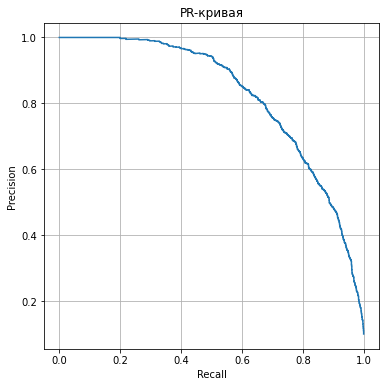

F1 = 0.716
Recall = 0.631
Precision = 0.829


In [ ]:
# тестирование SentanceTranformer на Logistic Regression
LogRer_emb = LogisticRegression(solver = 'sag', random_state = RANDOM_STATE)
LogRer_emb.fit(X_train_emb, Y_train_emb)
prediction_valid = LogRer_emb.predict(X_valid_emb)
proba_valid = LogRer_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=(6, 6))
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, prediction_valid)))

<a id='section_4B'></a>
### CatBoost (CPU)

In [ ]:
# модель градиентного бустинга CatBoost
CatBoost_cpu_emb = CatBoostClassifier(verbose = 100,
                                      task_type = "CPU",
                                      eval_metric = 'F1', # метрика оценки модели 
                                      early_stopping_rounds = 200) # макс. кол-во итераций обучения

In [ ]:
# обучение CatBoost на фичах SentanceTranformer (CPU) 4:30 minutes
CatBoost_cpu_emb.fit(X_train_emb, Y_train_emb)

Learning rate set to 0.081637
0:	learn: 0.2639841	total: 447ms	remaining: 7m 26s
100:	learn: 0.6463136	total: 36s	remaining: 5m 20s
200:	learn: 0.6966901	total: 1m 8s	remaining: 4m 34s
300:	learn: 0.7312032	total: 1m 40s	remaining: 3m 53s
400:	learn: 0.7581250	total: 2m 12s	remaining: 3m 17s
500:	learn: 0.7792380	total: 2m 42s	remaining: 2m 42s
600:	learn: 0.7962165	total: 3m 13s	remaining: 2m 8s
700:	learn: 0.8134824	total: 3m 43s	remaining: 1m 35s
800:	learn: 0.8288155	total: 4m 12s	remaining: 1m 2s
900:	learn: 0.8449129	total: 4m 42s	remaining: 31s
999:	learn: 0.8584131	total: 5m 11s	remaining: 0us


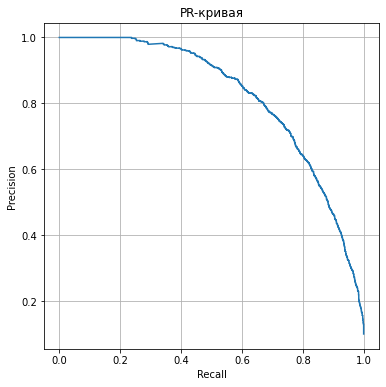

F1 = 0.710
Recall = 0.614
Precision = 0.841


In [ ]:
# тестирование SentanceTranformer на CatBoost (CPU)
prediction_valid = CatBoost_cpu_emb.predict(X_valid_emb)
proba_valid = CatBoost_cpu_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=(6, 6))
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, prediction_valid)))

<a id='section_4C'></a>
### CatBoost (+ GPU)

In [ ]:
# модель градиентного бустинга CatBoost (GPU) 22 секунд
CatBoost_gpu_emb = CatBoostClassifier(verbose = 100,
                              task_type = "GPU",
                              eval_metric = 'F1',
                              early_stopping_rounds = 200)

In [ ]:
# обучение CatBoost на фичах SentanceTranformer (GPU) 22 секунд
CatBoost_gpu_emb.fit(X_train, Y_train)

Learning rate set to 0.025822
0:	learn: 0.3334906	total: 34.4ms	remaining: 34.3s
100:	learn: 0.5009477	total: 2.1s	remaining: 18.7s
200:	learn: 0.5994770	total: 6.69s	remaining: 26.6s
300:	learn: 0.6403855	total: 7.92s	remaining: 18.4s
400:	learn: 0.6600538	total: 9.07s	remaining: 13.6s
500:	learn: 0.6754930	total: 10.2s	remaining: 10.2s
600:	learn: 0.6878033	total: 11.3s	remaining: 7.51s
700:	learn: 0.6976851	total: 12.4s	remaining: 5.3s
800:	learn: 0.7055594	total: 13.5s	remaining: 3.35s
900:	learn: 0.7135106	total: 14.6s	remaining: 1.6s
999:	learn: 0.7193924	total: 15.7s	remaining: 0us


Метрика F1 = 0.677


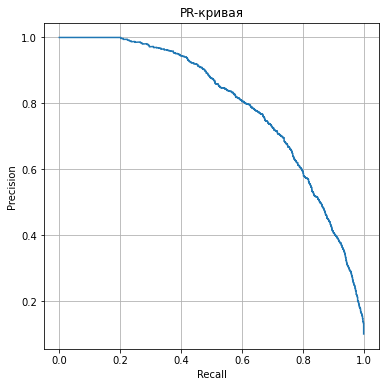

In [ ]:
# тестирование SentanceTranformer на CatBoost (GPU)
prediction_valid = CatBoost_gpu_emb.predict(X_valid_emb)
proba_valid = CatBoost_gpu_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=(6, 6))
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, prediction_valid)))

**Итог:**
- Лемматизация текста занимает около 2,5 минут. На этот процесс не влияет применение графического процессора.
- Процесс векторизации подготовленного текста с помощью `TfidfVectorizer` - мгновенный. Слова, не имеющие смысловой нагрузки - удалены.
- Логистическая регрессия имеет значение целевой метрики F1 = 0.72
- Градиентный бустинг CatBoost F1 = 0.76, но время обучения на CPU 16 минут. Применение GPU требует большого объема ОП, что не позволяет его запустить на базовых мощностях Colab.

Ключевым недостатком является большое количество признаков и объём памяти, которую они занимают. Это затрудняет использование GPU, к примеру для ускорения обучения модели CatBoost.

На данном этапе результат тестирования - приемлемый. Но необходимо учесть присутствующий дисбалланс классов. Этой теме будет посвящен отдельный раздел.

**Итог:**
- Кодирование текста (создание эбеддингов) с помощью GPU и предобученной модели из SentenceTransformer: 3,5 минуты (CPU 2 часа).
- Логистическая регрессия F1 = 0.72 и небольшое общее время работы: 20 секунд (обучение и предсказание).
- Градиентный бустинг CatBoost (CPU) F1 = 0.71 и 4,5 минут время обучения.
- Градиентный бустинг CatBoost (GPU) F1 = 0.68 и 25 секунд время обучения.

Это промежуточные результаты, поскольку в слеующем разделе эти же модели будут тестироваться с учётом присутствующим дисбалансом.


<a id='section_5'></a>
## Борьба с дисбалансом

<a id='section_5A'></a>
### Баланс классов

Использование встроенных средств модели, позволяющие стабилизировать разность между классами назначив им разные веса.

In [ ]:
# объявление Логистической регрессии с балансом классов
LR_balanced = LogisticRegression(solver = 'sag',
                                 class_weight = 'balanced',
                                 random_state = RANDOM_STATE)

In [ ]:
# тестирование TF-IDF на Logistic Regression + баланс классов
LR_balanced.fit(X_train_tfidf, Y_train_tfidf)
balanced_prediction_valid = LR_balanced.predict(X_valid_tfidf)

print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, balanced_prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, balanced_prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, balanced_prediction_valid)))

F1 = 0.750
Recall = 0.850
Precision = 0.671


In [ ]:
# тестирование SentanceTranformer на Logistic Regression + баланс классов
LR_balanced.fit(X_train_emb, Y_train_emb)
balanced_prediction_valid = LR_balanced.predict(X_valid_emb)

print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, balanced_prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, balanced_prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, balanced_prediction_valid)))

F1 = 0.648
Recall = 0.888
Precision = 0.510


Если ранее наблюдались заниженные значения полноты (Recall), то балансировка классов, за счёт изменения их веса, изменила положение на противоположное. Метрика F1 либо не изменилавь либо ухудшилась.

<a id='section_5B'></a>
### Изменение порога классификации

Поскольку в датасете присутствуют 2 класса, то по-умолчанию объекты распределяются либо в один класс либо в другой с вероятностью 50%.

Но в данной ситуации классы имеют разное соотношение друг к другу, а именно 1:9, не в пользу целевого класса (токсичные комментарии). В данном разделе будет смещаться порог классификации, ради повышения качества предсказания.

In [ ]:
# тестирование TF-IDF на Logistic Regression + смещение порога классификации (2 minutes)
proba_valid = LogRer_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

best_f1 = 0
for threshold in notebook.tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_tfidf, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

  0%|          | 0/15814 [00:00<?, ?it/s]

Наивысший показатель F1 = 0.783, при смещении порога до значения 0.25


In [ ]:
# тестирование SentanceTranformer на Logistic Regression + смещение порога классификации (2:20 minutes)
proba_valid = LogRer_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

best_f1 = 0
for threshold in notebook.tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_emb, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

  0%|          | 0/15925 [00:00<?, ?it/s]

Наивысший показатель F1 = 0.732, при смещении порога до значения 0.34


In [ ]:
# CatBoost TF-IDF + смещение порога классификации (1 minutes)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

best_f1 = 0
for threshold in notebook.tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_tfidf, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

  0%|          | 0/9073 [00:00<?, ?it/s]

Наивысший показатель F1 = 0.759, при смещении порога до значения 0.49


In [ ]:
# CatBoost SentanceTransformer + смещение порога классификации (2 minutes)
proba_valid = CatBoost_cpu_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

best_f1 = 0
for threshold in notebook.tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_emb, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

  0%|          | 0/15923 [00:00<?, ?it/s]

Наивысший показатель F1 = 0.737, при смещении порога до значения 0.31


Смещение порога классификации однозначно помогает учесть дисбаланс и повысить численность верноклассифицированных объектов.

<a id='section_5C'></a>
### Уменьшение выборки (DownSampling)

Поскольку исходный  датасет содержить большое количество объектов (160 тыс.), есть возможность воспользоваться этим, чтобы уменьшить многочисленный класс и воссоздать баланс.

In [ ]:
# деление признаков по классам
target_1   = df.loc[df['toxic'] == 1, 'toxic']
target_0   = df.loc[df['toxic'] == 0, 'toxic']
features_1 = df.loc[df['toxic'] == 1, 'lemm_text']
features_0 = df.loc[df['toxic'] == 0, 'lemm_text']

# уменьшение выборки многочисленного класса
target_downsampled   = pd.concat([target_0.sample(frac=(1/9),   random_state=RANDOM_STATE)] + [target_1])
features_downsampled = pd.concat([features_0.sample(frac=(1/9), random_state=RANDOM_STATE)] + [features_1])

# перемешивание объектов внутри выборки
X_train_ds, X_other, Y_train_ds, Y_other = train_test_split(features_downsampled,
                                                            target_downsampled,
                                                            train_size = 0.8,
                                                            random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_ds, X_test_ds, Y_valid_ds, Y_test_ds = train_test_split(X_other,
                                                                Y_other,
                                                                test_size = 0.50,
                                                                random_state = RANDOM_STATE)

In [ ]:
# "кодирование" текста
X_train_ds = count_tf_idf.transform(X_train_ds)
X_valid_ds = count_tf_idf.transform(X_valid_ds)
X_test_ds  = count_tf_idf.transform(X_test_ds)

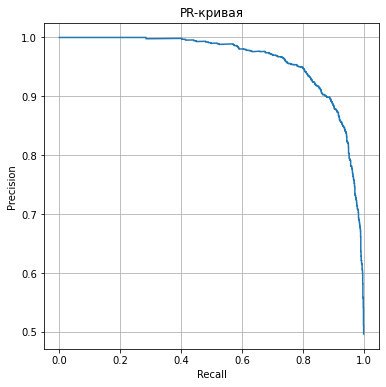

F1 = 0.879
Recall = 0.841
Precision = 0.920


In [ ]:
# тестирование TF-IDF на Logistic Regression
LogRer_tfidf_sd = LogisticRegression(solver = 'sag', random_state = RANDOM_STATE)
LogRer_tfidf_sd.fit(X_train_ds, Y_train_ds)
prediction_valid = LogRer_tfidf_sd.predict(X_valid_ds)
proba_valid = LogRer_tfidf_sd.predict_proba(X_valid_ds)
precision, recall, thresholds = precision_recall_curve(Y_valid_ds, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=(6, 6))
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_ds, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_ds, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_ds, prediction_valid)))

In [ ]:
# обучение CatBoost на ресемплированных фичах TF-IDF
CatBoost_tfidf.fit(X_train_ds, Y_train_ds)

0:	learn: 0.3480912	total: 408ms	remaining: 6m 47s
100:	learn: 0.8927336	total: 21.6s	remaining: 3m 12s
200:	learn: 0.9206914	total: 41.2s	remaining: 2m 43s
300:	learn: 0.9395926	total: 1m 1s	remaining: 2m 23s
400:	learn: 0.9513416	total: 1m 22s	remaining: 2m 3s
500:	learn: 0.9629658	total: 1m 42s	remaining: 1m 41s
600:	learn: 0.9724870	total: 2m 3s	remaining: 1m 21s
700:	learn: 0.9822787	total: 2m 24s	remaining: 1m 1s
800:	learn: 0.9903983	total: 2m 45s	remaining: 41.2s
900:	learn: 0.9969598	total: 3m 7s	remaining: 20.6s
999:	learn: 0.9993460	total: 3m 27s	remaining: 0us


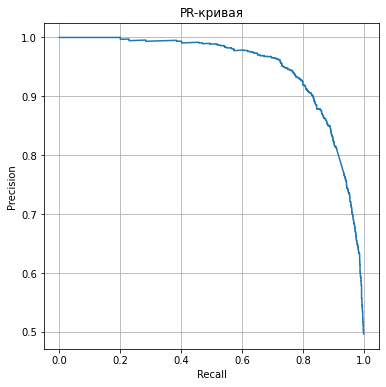

F1 = 0.865
Recall = 0.829
Precision = 0.904


In [ ]:
# тестирование TF-IDF на CatBoost (CPU) 12 minutes
prediction_valid = CatBoost_tfidf.predict(X_valid_ds)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_ds)
precision, recall, thresholds = precision_recall_curve(Y_valid_ds, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=(6, 6))
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_ds, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_ds, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_ds, prediction_valid)))

Уменьшение выборки позволило повысить значения всех рассматриваемых метрик, но фактически результат искуственный, поскольку игнорирует действительность.

<a id='section_6'></a>
## Итоговое тестирование

In [ ]:
# финальный тест TF-IDF на Logistic Regression + смещение порога классификации
proba_test = LogRer_tfidf.predict_proba(X_test_tfidf)
prediction_test = proba_test[:, 1] > 0.25

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_test_tfidf, prediction_test)))
print('Recall = {:.3f}'.format(recall_score(Y_test_tfidf, prediction_test)))
print('Precision = {:.3f}'.format(precision_score(Y_test_tfidf, prediction_test)))

F1 = 0.768
Recall = 0.741
Precision = 0.797


In [ ]:
# финальный тест TF-IDF на CatBoost + смещение порога классификации
proba_test = CatBoost_tfidf.predict_proba(X_test_tfidf)
prediction_test = proba_test[:, 1] > 0.49

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_test_tfidf, prediction_test)))
print('Recall = {:.3f}'.format(recall_score(Y_test_tfidf, prediction_test)))
print('Precision = {:.3f}'.format(precision_score(Y_test_tfidf, prediction_test)))

F1 = 0.765
Recall = 0.674
Precision = 0.883


**Выводы.**

Можно выделить основные критерии оценки модели:
- Время и ресурсы кодирование текста
- Время и ресурсы обучения модели
- Время предсказания
- Итоговое значение метрики

Логистическая регрессия в кооперативе с TF-IDF векторизатором являются наилучшим результатом, поскольку подготовка и кодирование занимает наименьшее время (2-3 минуты), обучение регрессии (20 секунд), предсказание - мгновенное. Для работы такой пары не требуется GPU в качестве аппаратного ускорителя.

Итоговое значение метрикики F1 практически одинаково для обеих моделей, но у Логистической регресии, оно более сбалансированно, если посмотреть на значения Recall и Precision.

Модель CatBoost может выдать предсказания более высшего качества, но для этого требуется более крапотливая настройка её гиперпараметров и дополнительное время работы. Процесс сильно зависим от технических мощностей компьютера/сервера.

<a id='section_7'></a>
## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны